# Lesson 2: parameter specification
**Author: Su Ye (remotesensingsuy@gmail.com)**

**Time series datasets: Landsat 5,7,8 dataset**

**Application: insect disturbances in CO and MA, USA**

While the default parameter for the CCDC-like algorithms have been rigorously verified, its performance might be not the optimal for some specific disturbance types. This lesson will show the effects of different parameter settings for detecting disturbances, which provides guidance for COLD/S-CCD parameter setting.

---


## Probability of Change

One of the influential parameter for CCDC-like approaches is Probability of Change (`p_cg`). COLD/S-CCD determine a break by combining the change magnitudes from all involved spectral bands into a norm. Statistically, the norm of the change-magnitude vector follows a chi-square distribution. The parameter `p_cg` specifies the probability level used to define the critical value of this distribution, thereby determining the threshold for how much an observation must deviate from the predicted COLD/S-CCD curve to be flagged as a break.

The Mountain Pine Beetle (MPB) outbreak caused extensive tree mortality in the Rocky Mountains of Colorado, beginning around 2003 and peaking in 2007. Following infestation, attacked trees typically remained green for approximately one year (the “green stage”), then transitioned to red within the next year as needles lost chlorophyll, and eventually progressed to a gray stage as defoliation occurred. A major challenge for remote sensing–based MPB monitoring is that the spectral change magnitude during the initial infestation stage is often subtle, since needles remain largely intact and retain green coloration. Consequently, the default disturbance detection threshold in S-CCD/COLD (e.g., `p_cg = 0.99`), which was calibrated for capturing generic disturbance events, may not be sufficiently sensitive to identify the early spectral signals associated with beetle activity.

We will use a Landsat-based time series from an MPB-affected site in Colorado, USA, to exemplify disturbance monitoring using S-CCD.

### Default parameters

In [1]:
import numpy as np
import pathlib
import pandas as pd

# Imports from this package
from pyxccd import sccd_detect


TUTORIAL_DATASET = (pathlib.Path.cwd() / 'datasets').resolve() # modify it as you need
assert TUTORIAL_DATASET.exists()
in_path = TUTORIAL_DATASET/ '2_mpb_co_landsat.csv' # read the MPB-affected plot in CO

# read example csv for HLS time series
data = pd.read_csv(in_path)

# split the array by the column
dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, sensor = data.to_numpy().copy().T
sccd_result = sccd_detect(dates, blues, greens, reds, nirs, swir1s, swir2s, qas, p_cg=0.999)

sccd_result.rec_cg

array([], dtype=float64)

The change record `rec_cg` is none, which means that S-CCD doesn't detect any break using the default parameters. Let's dive into the time series using SWIR2, which is the most sensitive band to water stress:

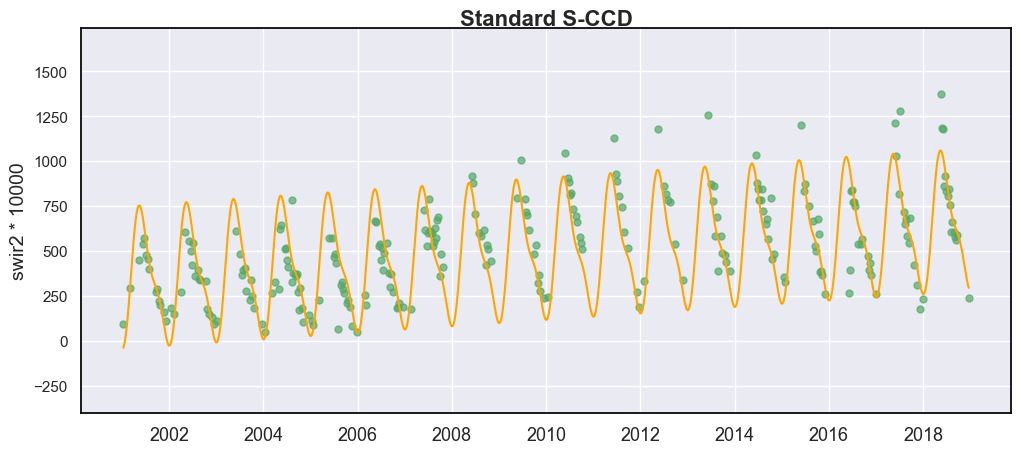

In [2]:
from datetime import date
from typing import List, Tuple, Dict, Union, Optional
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from pyxccd.common import SccdOutput
from pyxccd.utils import getcategory_sccd, defaults

def display_sccd_result(
    data: np.ndarray,
    band_names: List[str],
    band_index: int,
    sccd_result: SccdOutput,
    axe: Axes,
    title: str = 'S-CCD',
    plot_kwargs: Optional[Dict] = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Compare COLD and SCCD change detection algorithms by plotting their results side by side.
    
    This function takes time series remote sensing data, applies both COLD and SCCD algorithms,
    and visualizes the curve fitting and break detection results for comparison. 
    
    Parameters:
    -----------
    data : np.ndarray
        Input data array with shape (n_observations, n_bands + 2) where:
        - First column: ordinal dates (days since January 1, AD 1)
        - Next n_bands columns: spectral band values
        - Last column: QA flags (0-clear, 1-water, 2-shadow, 3-snow, 4-cloud)
        
    band_names : List[str]
        List of band names corresponding to the spectral bands in the data (e.g., ['red', 'nir'])
        
    band_index : int
        1-based index of the band to plot (e.g., 0 for first band, 1 for second band)
        
    sccd_result: SccdOutput
        Output of sccd_detect
    
    axe: Axes
        An Axes object represents a single plot within that Figure
    
    title: Str
        The figure title. The default is "S-CCD"
        
    plot_kwargs : Dict, optional
        Additional keyword arguments to pass to the display function. Possible keys:
        - 'marker_size': size of observation markers (default: 5)
        - 'marker_alpha': transparency of markers (default: 0.7)
        - 'line_color': color of model fit lines (default: 'orange')
        - 'font_size': base font size (default: 14)
        
    Returns:
    --------
    Tuple[plt.Figure, List[plt.Axes]]
        A tuple containing the matplotlib Figure object and a list of Axes objects
        (top axis is COLD results, bottom axis is SCCD results)
    
    """
    w = np.pi * 2 / 365.25

    # Set default plot parameters
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # Extract values with proper type casting
    font_size = default_plot_kwargs.get('font_size', 14)
    try:
        title_font_size = int(font_size) + 2
    except (TypeError, ValueError):
        title_font_size = 16 


    # Clean and prepare data
    data = data[np.all(np.isfinite(data), axis=1)]
    data_df = pd.DataFrame(data, columns=['dates'] + band_names + ['qa'])


    # Plot COLD results
    w = np.pi * 2 / 365.25
    slope_scale = 10000

    # Prepare clean data for COLD plot
    data_clean = data_df[(data_df['qa'] == 0) | (data_df['qa'] == 1)].copy()
    data_clean =  data_clean[(data_clean >= 0).all(axis=1) & (data_clean.drop(columns="dates") <= 10000).all(axis=1)]
    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, 'dates_formal'] = calendar_dates
    
    # Calculate y-axis limits
    band_name = band_names[band_index]
    band_values = data_clean[data_clean['qa'] == 0 | (data_clean['qa'] == 1)][band_name]
    # band_values  = band_values[band_values <10000]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra

    # Plot SCCD observations
    axe.plot(
        'dates_formal', band_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    # Plot SCCD segments
    for segment in sccd_result.rec_cg:
        j = np.arange(segment['t_start'], segment['t_break'] + 1, 1)
        if len(segment['coefs'][band_index]) == 8:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                'trimodal': np.cos(3 * w * j) * segment['coefs'][band_index][6] + np.sin(3 * w * j) * segment['coefs'][band_index][7]
            })
        else:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                'trimodal': j * 0
            })
        plot_df['predicted'] = (
            plot_df['trend'] + 
            plot_df['annual'] + 
            plot_df['semiannual']+
            plot_df['trimodal']
        )

        # Convert dates and plot model fit
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    # Plot near-real-time projection for SCCD if available
    if hasattr(sccd_result, 'nrt_mode') and (sccd_result.nrt_mode %10 == 1 or sccd_result.nrt_mode == 3 or sccd_result.nrt_mode %10 == 5):
        recent_obs = sccd_result.nrt_model['obs_date_since1982'][sccd_result.nrt_model['obs_date_since1982']>0]
        j = np.arange(
            sccd_result.nrt_model['t_start_since1982'].item() + defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'], 
            recent_obs[-1].item()+ defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH']+1, 
            1
        )

        if len(sccd_result.nrt_model['nrt_coefs'][band_index]) == 8:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                'trimodal': np.cos(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][6] + np.sin(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][7]
            })
        else:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                'trimodal': j * 0
            })
            
        plot_df['predicted'] = plot_df['trend'] + plot_df['annual'] + plot_df['semiannual']+ plot_df['trimodal']
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    # Plot breaks
    for i in range(len(sccd_result.rec_cg)):
        if getcategory_sccd(sccd_result.rec_cg, i) == 1:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='k')
        else:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='r')
    
    axe.set_ylabel(f"{band_name} * 10000", fontsize=default_plot_kwargs['font_size'])

    # Handle tick params with type safety
    tick_font_size = default_plot_kwargs['font_size']
    if isinstance(tick_font_size, (int, float)):
        axe.tick_params(axis='x', labelsize=int(tick_font_size)-1)
    else:
        axe.tick_params(axis='x', labelsize=13)  # fallback

    axe.set(ylim=(ylim_low, ylim_high))
    axe.set_xlabel("", fontsize=6)

    # Format spines
    for spine in axe.spines.values():
        spine.set_edgecolor('black')
    axe.set_title(title, fontweight="bold", size=title_font_size, pad=2)
    
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 5))

display_sccd_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=5, sccd_result=sccd_result, axe=ax, title="Standard S-CCD")

From the figure, an increasing trend is observed in the SWIR band, indicating intensifying water stress, even though S-CCD didn't detect any break. This increasing trend is the signal for this pixel under beetle attack.

### Decomposing signals
To verify this visually identified trend, we will examine the `states` tool provided by S-CCD. In the context of a state-space model, the state represents the condition of the land surface signal at time $t+1$ for band $i$, which could be recursively updated the filterred state $a_{t|t,i}$ at time $t$: 

$$a_{t+1,i}=Ta_{t|t,i}$$


Where $T$ is a transformation matrix. For each band, the `states` $a$ consists of three time-varying elements, trend, annual, semi-annual, and trimodal (if available). These `states` allows a within-segment analyses of seasonality, long-term trends, and other dynamics, thereby complementing the spectral breaks detected by S-CCD. We will present more details for `state analysis` in Lesson 5. 

To output the states, the users could simply set the parameter `state_intervaldays` in `sccd_detect` function as a non-zero integer (commonly set to 1, meaning states are output on a daily basis), and `sccd_detect` will yield the structured object for S-CCD normal output as well as additional state records:


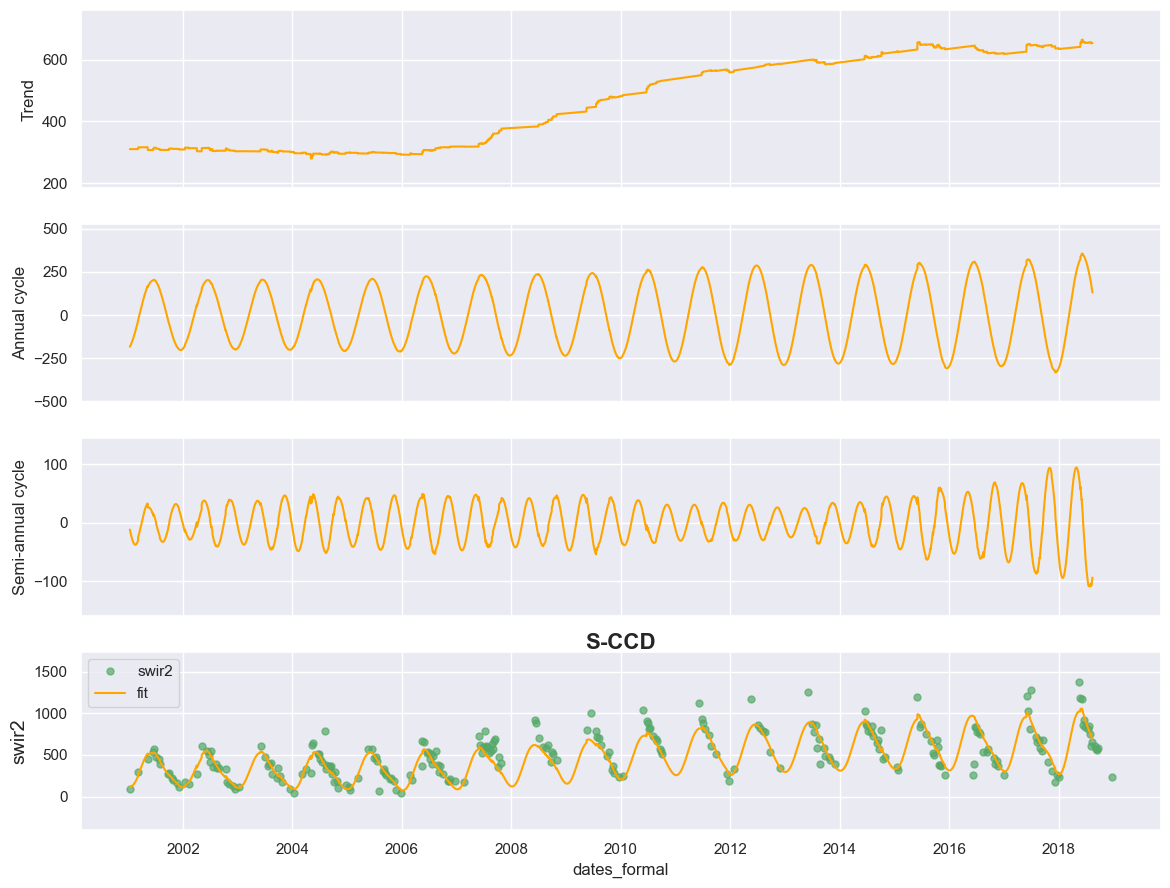

In [3]:
def display_sccd_states_flex(
    data_df: pd.DataFrame,
    states:pd.DataFrame,
    axes: Axes,
    variable_name: str,
    title:str,
    band_name:str = "b0",
    plot_kwargs: Optional[Dict] = None
):
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # convert ordinal dates to calendar
    formal_dates = [pd.Timestamp.fromordinal(int(row)) for row in states["dates"]]
    states.loc[:, "dates_formal"] = formal_dates  

    extra = (np.max(states[f"{band_name}_trend"]) - np.min(states[f"{band_name}_trend"])) / 4
    axes[0].set(ylim=(np.min(states[f"{band_name}_trend"]) - extra, np.max(states[f"{band_name}_trend"]) + extra))
    sns.lineplot(x="dates_formal", y=f"{band_name}_trend", data=states, ax=axes[0], color="orange")
    axes[0].set(ylabel=f"Trend")

    extra = (np.max(states[f"{band_name}_annual"]) - np.min(states[f"{band_name}_annual"])) / 4
    axes[1].set(ylim=(np.min(states[f"{band_name}_annual"]) - extra, np.max(states[f"{band_name}_annual"]) + extra))
    sns.lineplot(x="dates_formal", y=f"{band_name}_annual", data=states, ax=axes[1], color="orange")
    axes[1].set(ylabel=f"Annual cycle")

    extra = (np.max(states[f"{band_name}_semiannual"]) - np.min(states[f"{band_name}_semiannual"])) / 4
    axes[2].set(ylim=(np.min(states[f"{band_name}_semiannual"]) - extra, np.max(states[f"{band_name}_semiannual"]) + extra))
    sns.lineplot(x="dates_formal", y=f"{band_name}_semiannual", data=states, ax=axes[2], color="orange")
    axes[2].set(ylabel=f"Semi-annual cycle")


    data_clean = data_df[(data_df["qa"] == 0) | (data_df['qa'] == 1)].copy() # CCDC also processes water pixels
    formal_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, "dates_formal"] = formal_dates  # convert ordinal dates to calendar
    axes[3].plot(
        'dates_formal', variable_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    states["General"] = states[f"{band_name}_annual"] + states[f"{band_name}_trend"] + states[f"{band_name}_semiannual"]
    g = sns.lineplot(
        x="dates_formal", y="General", data=states, label="fit", ax=axes[3], color="orange"
    )
            
    axes[3].set_ylabel(f"{variable_name}", fontsize=default_plot_kwargs['font_size'])
    axes[3].set_title(title, fontweight="bold", size=16 , pad=2)
    
    band_values = data_df[data_df['qa'] == 0][variable_name]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra
    axes[3].set(ylim=(ylim_low, ylim_high))
    


# Set up plotting style
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# Create figure and axes
fig, axes = plt.subplots(4, 1, figsize=[12, 10], sharex=True)
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.1)

# specify state_intervaldays as a non-zero value to output states
sccd_result, states = sccd_detect(dates, blues, greens, reds, nirs, swir1s, swir2s, qas, state_intervaldays=1)
display_sccd_states_flex(data_df=data, axes=axes,states=states, band_name="swir2", variable_name="swir2", title="S-CCD")

From the `Trend` component (the first subfigure), we identified a significantly increasing trend for SWIR2, which confirms that this forest pixel was attacked by beetle. The initial lifting signal occurs in 2007-ish.

### Adjusting p_cg

Now we tried to detect the break by adjusting `p_cg` to a lower value. The parameter `p_cg`, which represents the chi-square probability for change, defines the spectral threshold at which a break is detected. By default, `p_cg` is set to 0.99. In this case, S-CCD was able to detect the break more accurately when we lowered `p_cg` to 0.7. 

It is worth noting that two breaks were identified: the first was automatically labeled as a “recovery” by `getcategory_sccd` (which is based upon rule sets), and therefore marked with a red line.

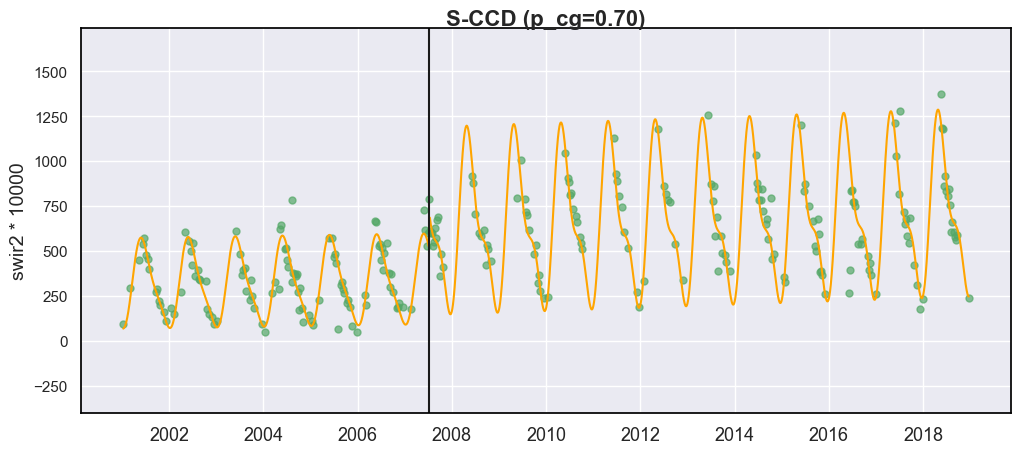

In [4]:
fig, ax = plt.subplots(figsize=(12, 5))


sccd_result = sccd_detect(dates, blues, greens, reds, nirs, swir1s, swir2s, qas, p_cg=0.70)
display_sccd_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=5, sccd_result=sccd_result, axe=ax, title="S-CCD (p_cg=0.70)")

## Number of consecutive observations

Another important parameter for S-CCD/COLD is the number of consecutive observations that deviated from the predicted value with change magnitude over the threshold, i.e., `conse`. `Conse` sometime is also named as **the width of peek window**. The default value for `conse` is 6, meaning that a break is identified only when at least six consecutive break observations for a peek window were identified, each causing spectral change magnitude larger than the critical value of the chi-square distribution at the probability `p_cg`. If the disturbances is short-lived and recovered soon (such as drought, flood), then S-CCD may miss the break as `conse=6` is not satified.

The spongy moth (SM) is such a ephemeral defoliating insect native to Europe and Asia, and was accidentally introduced into Massachusetts in 1869. In New England, spongy moth outbreaks are episodic but severe, driven by interactions between climate, host availability (oak dominance), and natural enemies. The 2015–2018 outbreak highlighted how drought can tip the balance toward insect population explosions, resulting in large-scale forest defoliation and elevated tree mortality. The spongy moths hatch eggs typically in late April, and puplated in late June causing defoliation which led to significantly NIR decrease, but many hardwoods (oaks, maples, birch) will re-leaf by late July or August, making it a typical ephemeral disturbance.

### NIR vs SWIR2
Let's use the default parameter of SCCD to detect a spongy moth site in MA, USA, and plot the results using NIR and SWIR2 band: 

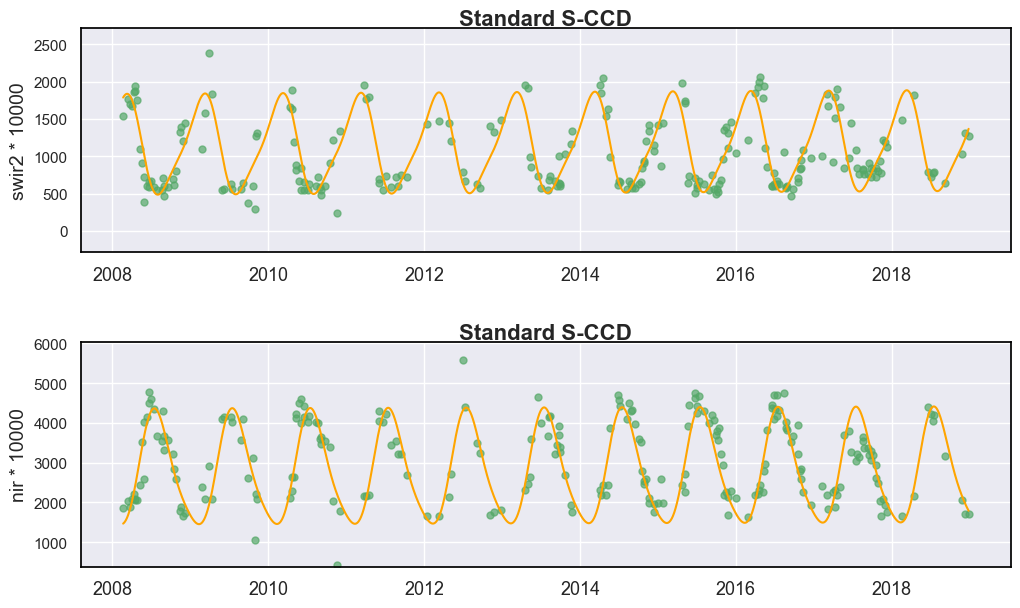

In [5]:

in_path = TUTORIAL_DATASET/ '2_sm_ma_landsat.csv' # read the MPB-affected plot in CO

# read example csv for HLS time series
data = pd.read_csv(in_path)

dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, sensor = data.to_numpy().copy().T

# using the default parameters
sccd_result = sccd_detect(dates, blues, greens, reds, nirs, swir1s, swir2s, qas)

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

display_sccd_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=5, sccd_result=sccd_result, axe=axes[0], title="Standard S-CCD")

display_sccd_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=3, sccd_result=sccd_result, axe=axes[1], title="Standard S-CCD")

Here are two findings. 1) we can observe an obviously decrease in the summer of 2017 in NIR while the change signal is not straightforward for SWIR2 as MPB, which reflects different physiological response of trees to defoliator and borer (borers tunnel and feed inside the plant's woody parts). 2) it is visual from time series for that there is an NIR decrease in 2017, but due to the duration of the disturbance is too short, S-CCD fails to detect it.

### Adjusting conse
Let's adjust the conse:

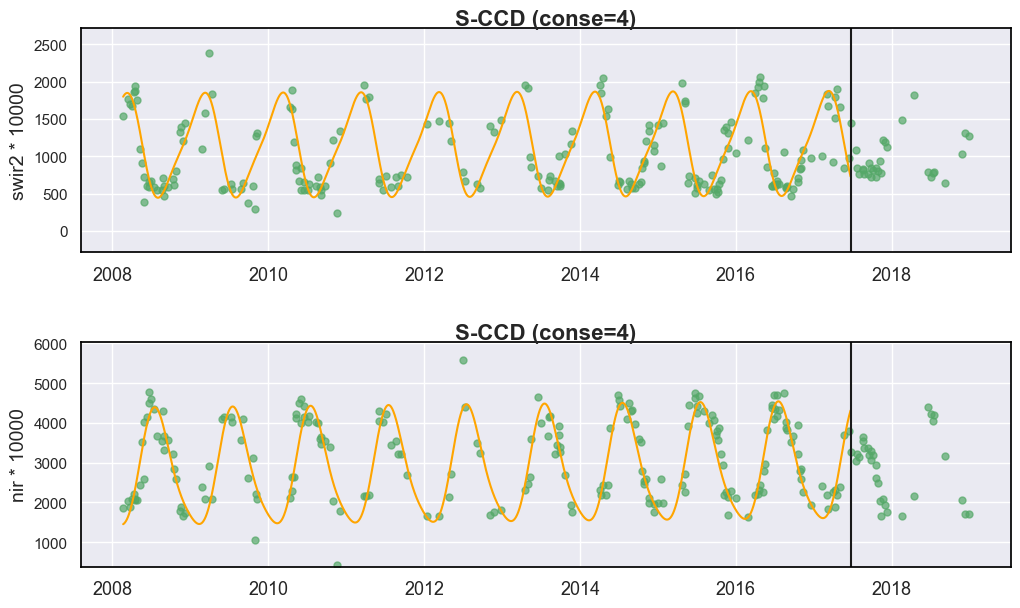

In [6]:
# lowering conse to 4
sccd_result = sccd_detect(dates, blues, greens, reds, nirs, swir1s, swir2s, qas, conse=4)

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

display_sccd_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=5, sccd_result=sccd_result, axe=axes[0], title="S-CCD (conse=4)")

display_sccd_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=3, sccd_result=sccd_result, axe=axes[1], title="S-CCD (conse=4)")

By decreasing conse from 6 to 4, we were able to successfully detect the spectral break induced by spongy moth infestation. It is important to note that standard S-CCD/COLD identifies a single break based on the combined change magnitudes across five spectral bands (green, red, NIR, SWIR1, SWIR2). As a result, all five bands share the same breakpoint, even though the SWIR2 band does not exhibit an obvious spectral change.

No curve fitting is available for the second segment in this case, because there were not enough observations to initialize a near real-time (NRT) model. To verify this, one can inspect the second digit of nrt_mode: a value of 2 indicates that the model has not yet been initialized, while a value of 1 indicates that an NRT model is available.

In [7]:
print(f"The second digit of nrt_mode is {sccd_result.nrt_mode % 10}")

The second digit of nrt_mode is 2


## Summary
Reducing `conse` and `p_cg` improves the sensitivity of break detection, as fewer consecutive outlier observations or lower change-magnitude thresholds are required to flag a change. However, such adjustments also increase the likelihood of false positives (commission errors), where short-term noise or weather-related anomalies may be misclassified as breaks. For this reason, both `conse` and `p_cg` should be tuned carefully. A parameter sensitivity analysis is recommended when the goal is to capture subtle land surface changes. Another common strategy is to apply more aggressive parameter settings to maximize sensitivity and then use a machine-learning classifier to isolate the specific changes of interest.